**извлечение признаков из текста на естественном языке**

word2vec : skip-gram


Евгений Борисов <esborisov@sevsu.ru>

Jay Alammar Word2vec в картинках. (перевод - Анатолий Ализар)   
https://habr.com/ru/articles/446530/

## загружаем текст 

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

In [2]:
# import gzip
# with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

In [3]:
text = text[330:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:355])

символов:638466
---------------

ЖЕЛТЫЕ КОРОЛИ 
     Записки нью-йоркского таксиста


     Товарищам моим -- белым и черным, американцам и эмигрантам  из России и
Израиля,  из  Греции  и  Кореи,  арабам,  китайцам,  полякам  и всем  прочим
таксистам города  Нью-Йорк  в знак глубокого  уважения к  их нечеловеческому
труду эту горькую книгу посвящаю...

     Водитель No 320718
     

   


## выполняем токенизацию

In [4]:
import re
import numpy as np
from numpy import random as rng

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

nltk version: 3.8.1


In [6]:
from random import sample
from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.corpus import stopwords as nltk_stopwords

# выполняем токенизацию
sentences = [ 
    [ # разбираем предложения на отдельные слова
     t.lower() for t in nltk_tokenize_word(s) 
     if re.match(r'[а-я -]+',t.lower()) and len(t)>1 # выкидываем цифры, отдельные символы и т.п. 
    ] 
    for s in nltk_sentence_split(text) # режем текст на отдельные предложения
]

print(f'предложений: {len(sentences)}\n------------------\n')

sample(sentences,5)

предложений: 6686
------------------



[['но',
  'ведь',
  'так',
  'нестерпимо',
  'хотелось',
  'тут',
  'сделал',
  'то',
  'из',
  'чего',
  'потом',
  'родилась',
  'эта',
  'книжка'],
 ['мелкий',
  'бруклинский',
  'подрядчик',
  'выхватил',
  'горящий',
  'заказ',
  'срочно',
  'смонтировать',
  'сантехнику',
  'надстройке',
  'на',
  'парк-авеню'],
 ['они',
  'поняли',
  'что',
  'предоставляемые',
  'здесь',
  'блага',
  '--',
  'реальны',
  'запреты',
  '--',
  'условны'],
 ['она',
  'сумела',
  'превозмогая',
  'себя',
  'оторваться',
  'на',
  'минутку',
  'от',
  'конопатых',
  'девочек',
  'тем',
  'чтобы',
  'частицу',
  'своего',
  'внимания',
  'уделить',
  'таксисту'],
 ['обеду',
  'был',
  'уже',
  'пьяный',
  'без',
  'водки',
  'стоявшие',
  'вокруг',
  'нас',
  'таксисты',
  'заржали']]

In [7]:
words = sorted(set(sum(sentences,[]))) # список слов из текста
vocab =  { w:i for i,w in enumerate(words) } # пронумерованный словарь 
del words

In [8]:
n_words = len(vocab) # количество слов в словаре
print( f'размер словаря: {n_words} слов')

размер словаря: 22062 слов


In [10]:
# vocab

## собираем контексты

In [11]:
from nltk.util import ngrams as nltk_ngrams

# вынимаем все n-gram из текста

ngram_len = 5

text_ngrams = [ 
    ngram for s in sentences if len(s)>ngram_len
    for ngram in nltk_ngrams(s,ngram_len) 
]
print('количество n-gram: %i'%(len(set(text_ngrams))))
sample(text_ngrams,5)

количество n-gram: 57205


[('неудобной', 'позе', 'сгорбилась', 'женщина', 'лет'),
 ('отелям', 'хилтон', 'шератон', 'мало', 'того'),
 ('неисчерпаемый', 'колодец', 'фартовых', 'таксистских', 'долларов'),
 ('они', 'ведь', 'такие', 'чихнет', '--'),
 ('ужас', 'все', 'омерзение', 'как', 'сломался')]

In [12]:
# сокращаем учебный набор для ускорения процесса
# text_ngrams = sample(text_ngrams,1024)
text_ngrams = sample(text_ngrams,128) 

### кодируем слова

In [13]:
T = np.array([ [ vocab[w] for w in ngrams ] for ngrams in text_ngrams ]) # кодируем слова

wn = ngram_len//2

W = T[:,wn] # коды слов
C = np.delete(T,wn,axis=1) # коды слов контекста

assert len(C) == len(W)

C.shape, W.shape

((128, 4), (128,))

In [14]:
del text_ngrams
del text
del T

In [15]:
# # унитарное кодирование слов (one-hot-encoding)
E = np.eye(n_words,dtype=np.int8)

Wbin = np.vstack([ E[c] for c in W ])
Cbin = np.vstack([ np.vstack([ E[c] for c in Ci ])[np.newaxis,:] for Ci in C ]) 

Cbin.shape, Wbin.shape

((128, 4, 22062), (128, 22062))

In [16]:
del W
del C

## строим модель Skip-Gram

In [17]:
# будем по контексту предсказывать слово

In [18]:
# ф-ция активации скрытого слоя - линейная
# def act(s): return s

# ф-ция активации выходного слоя
def softmax(s): 
    e = np.exp(s)
    return e/e.sum(axis=1).reshape(s.shape[0],1)

In [19]:
def w2v_step(W,Vi,Vo):
    H = W.dot(Vi) # значения скрытого слоя
    U = H.dot(Vo) # состояния выходного слоя
    O = softmax(U) # выход сети
    return H,U,O


Функция потери

$$E = \left| \sum\limits_i\log\left( \sum\limits_k \exp(U_{ik}) \right) - \sum\limits_i\sum\limits_k\sum\limits_j (U_{ik} * Q_{ijk}) \right| $$


$U_{ik}$ состояние k-того нейрона выходного слоя для слова $i$     
$Q_{ij}$ слово $j$ контекста слова $i$   
где ∗ - операция поэлементного умножения векторов

In [20]:
def w2v_loss(U,C):
    n,cws,v = C.shape 
    # количество примеров
    # размер окна контекста   
    # количество слов в словаре

    Us = np.log( np.exp(U).sum(axis=1) ).sum()

    Uo = 0.0
    for i in range(cws): # для всех слов контекста
        Ci = C[:,i,:].reshape([n,v]) # набор слов контекста i
        Uo += (U*Ci).sum() # значения выходного слоя для слов x контекста i

    return np.abs(Us-Uo)/n

In [21]:
def w2v_grad(C,W,H,O,Vo):
    n,cws,v = C.shape
        # количество примеров
        # размер окна контекста   
        # количество слов в словаре

    gVi = gVo = 0.0 

    for i in range(cws):
        Ci = C[:,i,:].reshape([n,v]) # слово i контекста
        D = O - Ci # ошибка на слове контекста i
        gVo += D.T.dot(H).T
        gVi += W.T.dot(D).dot(Vo.T)

    return gVi,gVo

In [22]:
def w2v_weigth_norm(v,w):
    nn = np.linalg.norm( np.hstack([ v.flatten(), w.flatten() ]) )
    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()
    return (v/nn,w/nn) if nn!=0.0 else (v,w)

### обучаем модель

In [23]:
n = Wbin.shape[1] # количество слов в словаре
k = 30 # размер скрытого слоя H

Vi = rng.normal(scale=.01,size=(n,k))
Vo = rng.normal(scale=.01,size=(k,n))

In [24]:
from tqdm.auto import tqdm

In [25]:
er = [1e10,]

In [26]:
%%time

a = .91 # скорость обучения

n_steps = 48

for i in tqdm(range(n_steps)):
    H,U,O = w2v_step(Wbin,Vi,Vo) # вычисляем состояния слоёв и выход
    er.append(w2v_loss(U,Cbin)) # вычисляем ошибку
    #print(i+1, er[-1])
    if er[-1]>er[-2]: 
        Vi, Vo = Vi_old, Vo_old
        break
        
    gVi, gVo = w2v_grad(Cbin,Wbin,H,O,Vo) # вычисляем градиент ф-ции потери
    gVi,gVo = w2v_weigth_norm(gVi,gVo) # нормируем значения градиента
    Vi_old, Vo_old =  Vi, Vo # сохраняем старые веса
    Vi,Vo = Vi-a*gVi, Vo-a*gVo # корректируем веса

  0%|          | 0/48 [00:00<?, ?it/s]

CPU times: user 19min 7s, sys: 1min 40s, total: 20min 47s
Wall time: 3min 57s


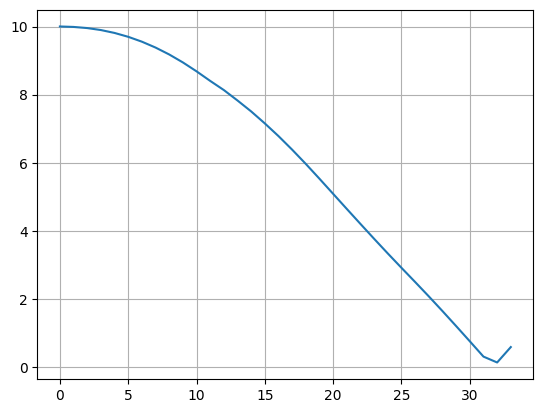

In [27]:
from matplotlib import pyplot as plt

er=er[1:]
plt.plot(er)
plt.grid()
plt.show()

## оцениваем результат

In [28]:
from sklearn.metrics.pairwise import pairwise_distances

In [29]:
D = pairwise_distances(Vi) # матрица расстояний
R = np.argsort(D) # номера слов в порядке увеличения расстояния

In [30]:
from numpy import random as rng

In [31]:
vocab_ = { v:k for k,v in vocab.items() } # нумеруем слов в словаре

nn = rng.permutation(len(vocab))[:20] # выбираем случайно N слов

# для выбранных слов печатаем близкие по w2v
{ vocab_[i] : [ vocab_[j] for j in  R[i,1:5]  ] for i in nn }

{'показываю': ['деятель', 'одобрении', 'ошибок', 'предыдущего'],
 'алкаша-лаборанта': ['защелкнуты', 'комментировал', 'комиссия', 'посидишь'],
 'вслед': ['подвал', 'ценам', 'воспитанность', 'провинциальные'],
 'двадцатидвухчасового': ['хватает', 'внимательно', 'рот', 'горбатой'],
 'исследования': ['подробностью', 'заключали', 'занятыми', 'возвращаясь'],
 'исчерпан': ['заклепке', 'население', 'выдавать', 'ахнула'],
 'прогуливают': ['смешение', 'лужица', 'установленные', 'растений'],
 'гостиная': ['целей', 'лучший', 'бутылки', 'возмущенный'],
 'нехорошее': ['преимуществах', 'пожелал', 'кондиционеры', 'грота'],
 'удерживают': ['весов', 'пенсию', 'спрос', 'услуг'],
 'стал': ['ростовщиков', 'прыгали', 'извлекутся', 'тысяч'],
 'выруливал': ['пропадут', 'передвигая', 'путая', 'копейки'],
 'специальным': ['журнального', 'чуял', 'следы', 'посвящаю'],
 'морскому': ['удачно', 'незнакомых', 'блудный', 'шляпа'],
 'обернулся': ['снимут', 'дрогнуло', 'самозванец', 'подспорье'],
 'желтого': ['нашел', 